# Step-by-step MNIST Digits Classification - Simple Fully Connected Neural Network for MNIST Classification - PyTorch

In this example, we will see how to implement a simple fully connected neural network using PyTorch for classifying the digits in the MNIST dataset.

1. Set your data loader (manage batch size, pre-processing before sending dataset to GPU for training), explore your data

2. Define your model

3. Train your model with the appropriate loss function, optmizer, learning rate, batch_size, checkpoints, etc.

    3.1 If you are satisfied with the train and validation performance go to the next step

    3.2 If you are not satisfied with the train and validation performance go back to step 5

4. Test your model on the test and extract relevant metrics

In [ ]:
import torch # pytorch main library
import torchvision # computer vision utilities (deal with images)
import torchvision.transforms as transforms # transforms used in the pre-processing of the data

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [ ]:
# Function to get thge statistics of a dataset
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader: # batch data
        data = data[0] # Get the images to compute the stgatistics
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean,std

# functions to show an image
def imshow(img,stats):
    img = img *stats[1] + stats[0]     # unnormalize
    npimg = img.numpy() # convert the tensor back to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
batch_size = 256

transform = transforms.Compose(
    [transforms.ToTensor()]) # Convert the data to a PyTorch tensor (data type that pyTorch prefer)

# Load develpoment dataset
devset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform = transform)

train_set_size = int(len(devset) * 0.8)
val_set_size = len(devset) - train_set_size

# Split the development set into train and validation
trainset, valset = torch.utils.data.random_split(devset, [train_set_size, val_set_size], generator=torch.Generator().manual_seed(42))


# Get the data loader for the train set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Comopute the statistics of the train set
stats = get_dataset_stats(trainloader)
print("Train stats:", stats)
# Pre-processing transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((stats[0]), (stats[1]))])


# Load the development set again using the proper pre-processing transforms
devset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform = transform)

# Split the development set into train and validation
trainset, valset = torch.utils.data.random_split(devset, [train_set_size, val_set_size], generator=torch.Generator().manual_seed(42))

# Get the data loader for the train set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Get the data loader for the test set
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Get the test set
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

# Get the data loader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')



# -------------------- Take away ----------------------
# data loading using RAM, pre-processgin run in CPU
# training run in GPU
# -------------------- Take away ----------------------


# -------------------- Question ----------------------
# 1. what is num_works works for?

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.5MB/s]


Train stats: (tensor([0.1307]), tensor([0.3016]))


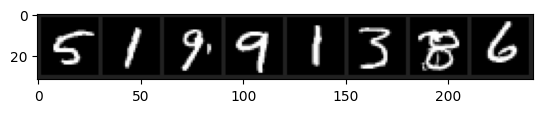

five  one   nine  nine  one   three eight six  


In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]), stats)
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

# -------------------- Question ----------------------
# 1. what is channel
# 28*28*1

In [ ]:
class Net(nn.Module):
    def __init__(self): # all layers
        super().__init__()
        # Define three layers:
        self.fc1 = nn.Linear(28*28, 120) # (stretched inputs - the size of the images: 28*28, outputs)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #( the size of the inputs in previous layer, number of classes)

    def forward(self, x): # explain how the data flow through the neural function (x = batch size)
        x = torch.flatten(x, 1) # flatten all dimensions except batch (turn into one dimension)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # in PyTorch, sofmax is only used in the loss function, instead of traning => save compute power
        return x


net = Net()
net.to(device) # move to the GPU

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss() # Loss function for classification (CrossEntropyLoss internally applies LogSoftmax and NLLLoss => no need to add softmax at the end of the Net)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Optimizer used for training

In [ ]:
nepochs = 20
PATH = './cifar_net.pth' # Path to save the best model (lower validation error)

best_loss = 1e+20
for epoch in range(nepochs):  # loop over the dataset multiple times
    #  ------ Training Loop ->> finding the best parameters (????) ------
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # compute the gradient decent of every previous parameters
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end = ' ')

    #  ------ Validaiton Loop ->> finding the best model ------
    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs => not helpful
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
        print(f'val loss: {val_loss / i:.3f}')

        # Save best model
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)

print('Finished Training')

1,  train loss: 1.925, val loss: 1.290
Saving model
2,  train loss: 0.828, val loss: 0.610
Saving model
3,  train loss: 0.509, val loss: 0.468
Saving model
4,  train loss: 0.415, val loss: 0.409
Saving model
5,  train loss: 0.368, val loss: 0.374
Saving model
6,  train loss: 0.340, val loss: 0.350
Saving model
7,  train loss: 0.318, val loss: 0.333
Saving model
8,  train loss: 0.301, val loss: 0.319
Saving model
9,  train loss: 0.288, val loss: 0.308
Saving model
10,  train loss: 0.276, val loss: 0.298
Saving model
11,  train loss: 0.266, val loss: 0.289
Saving model
12,  train loss: 0.257, val loss: 0.281
Saving model
13,  train loss: 0.248, val loss: 0.273
Saving model
14,  train loss: 0.240, val loss: 0.266
Saving model
15,  train loss: 0.234, val loss: 0.261
Saving model
16,  train loss: 0.227, val loss: 0.255
Saving model
17,  train loss: 0.220, val loss: 0.249
Saving model
18,  train loss: 0.214, val loss: 0.243
Saving model
19,  train loss: 0.209, val loss: 0.237
Saving model
20

In [ ]:
# Load the best model to be used in the test set
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

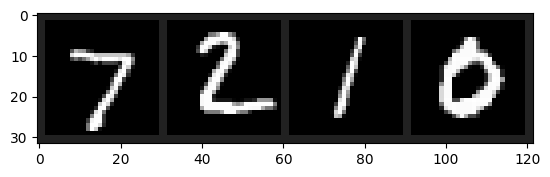

GroundTruth:  seven two   one   zero 


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)


# print images
imshow(torchvision.utils.make_grid(images[:4]), stats)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  seven two   one   zero 


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader: # using the dataloader which is from the CPU (哪裡有做把資料從 GPU 到 CPU)
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 94.05 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: zero  is 98.0 %
Accuracy for class: one   is 98.0 %
Accuracy for class: two   is 92.5 %
Accuracy for class: three is 93.2 %
Accuracy for class: four  is 95.3 %
Accuracy for class: five  is 90.9 %
Accuracy for class: six   is 95.4 %
Accuracy for class: seven is 93.8 %
Accuracy for class: eight is 91.0 %
Accuracy for class: nine  is 91.8 %
